<a href="https://colab.research.google.com/github/khaledwaleedsamir/optimize-and-deploy-DL-models/blob/mobilenet/Mobilenet_Trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds
# Import Dataset
(train_dataset, dev_dataset, test_dataset), info = tfds.load(
    'cats_vs_dogs',
    # Split the dataset 80% for training and 10% for dev and 10% for test
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)
# Verify dataset splits
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(dev_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.WE7JXT_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of training samples: 18610
Number of validation samples: 2326
Number of test samples: 2326


In [ ]:
import tensorflow as tf
# Normalize the image pixels to be from 0 to 1 (float32)
def normalize_img(image, label):
  return (tf.cast(image, tf.float32) / 255.0, label)
# Resize the image to 224x224
def resize(image, label):
  return (tf.image.resize(image, (224, 224)), label)

In [ ]:
# Preprocess the training set
SHUFFLE_VAL = len(train_dataset) // 100
BATCH_SIZE = 16
train_dataset = train_dataset.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(SHUFFLE_VAL)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
for x, y in train_dataset:
  print(x.shape, y.numpy())
  image_1 = x.numpy()
  break

(16, 224, 224, 3) [0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 1]


In [ ]:
# Preprocess the dev set
dev_dataset = dev_dataset.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
dev_dataset = dev_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
dev_dataset = dev_dataset.batch(BATCH_SIZE)
dev_dataset = dev_dataset.prefetch(tf.data.AUTOTUNE)

# Preprocess the test set
test_dataset = test_dataset.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf
# Import all necessary layers
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.layers import Input, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, AvgPool2D, Flatten, Dense, GlobalAveragePooling2D

In [ ]:
# MobileNet block
def mobilenet_block (x, filters, strides):
    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same', depthwise_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size=1, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    return x

In [ ]:
# The implementation of the model
def MobileNetV1():
  # Stem of the model
  input = Input(shape = (224,224,3))
  x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same', kernel_regularizer=regularizers.l2(0.01))(input)  # L2 regularization added
  x = BatchNormalization()(x)
  x = ReLU()(x)
  # Mobile net blocks (Main Part of the Model)
  x = mobilenet_block(x, filters = 64, strides = 1)
  x = mobilenet_block(x, filters = 128, strides = 2)
  x = mobilenet_block(x, filters = 128, strides = 1)
  x = mobilenet_block(x, filters = 256, strides = 2)
  x = mobilenet_block(x, filters = 256, strides = 1)
  x = mobilenet_block(x, filters = 512, strides = 2)
  for i in range (5):
     x = mobilenet_block(x, filters = 512, strides = 1)
  x = mobilenet_block(x, filters = 256, strides = 2)
  x = mobilenet_block(x, filters = 128, strides = 1)
  # Pooling and output
  x = GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.5)(x)  # Dropout layer to prevent overfitting
  # Apply L2 regularization to Dense layer
  output = Dense(units=1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(x)  # L2 regularization added
  model = Model(inputs=input, outputs=output)
  return model

model = MobileNetV1()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 112, 112, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d (DepthwiseConv2D)   │ (None, 112, 112, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_1 (DepthwiseConv2D) │ (None, 56, 56, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,501,825 (66.76 MB)

 Trainable params: 17,476,033 (66.67 MB)

 Non-trainable params: 25,792 (100.75 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs to wait before stopping
    restore_best_weights=True,  # Restore weights from the best epoch
    verbose=1
)
# Define a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by half
    patience=3,  # Wait for 3 epochs before reducing learning rate
    min_lr=1e-6,  # Lower bound of the learning rate
    verbose=1
)

In [ ]:
# Train the Model
model.fit(train_dataset, epochs=30, validation_data=dev_dataset, callbacks=[early_stopping, lr_scheduler])

Epoch 1/30
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 274s 189ms/step - accuracy: 0.5512 - loss: 9.0117 - val_accuracy: 0.6402 - val_loss: 8.1537 - learning_rate: 1.0000e-04
Epoch 2/30
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 187s 160ms/step - accuracy: 0.6395 - loss: 7.8261 - val_accuracy: 0.6750 - val_loss: 6.6994 - learning_rate: 1.0000e-04
Epoch 3/30
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 186s 160ms/step - accuracy: 0.6889 - loss: 6.3173 - val_accuracy: 0.6801 - val_loss: 5.2497 - learning_rate: 1.0000e-04
Epoch 4/30
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 202s 160ms/step - accuracy: 0.7395 - loss: 4.8395 - val_accuracy: 0.6174 - val_loss: 4.0695 - learning_rate: 1.0000e-04
Epoch 5/30
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 202s 159ms/step - accuracy: 0.7759 - loss: 3.6463 - val_accuracy: 0.8091 - val_loss: 2.9567 - learning_rate: 1.0000e-04
Epoch 6/30
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 203s 160ms/step - accuracy: 0.8057 - loss: 2.7889 - val_accuracy: 0.7214 - val_loss: 2.5805 - learning_rate: 1.0000e-04
Epoch 7/30
1164/1164 ━━━━━━━

In [ ]:
import numpy as np
import time

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict on test data
y_true = np.concatenate([y.numpy() for _, y in test_dataset])
y_pred = model.predict(test_dataset)
y_pred = np.where(y_pred > 0.5, 1, 0).flatten()  # Convert probabilities to binary predictions

146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9336 - loss: 0.8379
Test Accuracy: 93.38%
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=['Cat', 'Dog'])
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[1084   76]
 [  78 1088]]
Classification Report:
              precision    recall  f1-score   support

         Cat       0.93      0.93      0.93      1160
         Dog       0.93      0.93      0.93      1166

    accuracy                           0.93      2326
   macro avg       0.93      0.93      0.93      2326
weighted avg       0.93      0.93      0.93      2326



In [ ]:
from google.colab import files

# Upload images
uploaded = files.upload()

Saving Image1.jpg to Image1.jpg
Saving Image3.jpg to Image3.jpg
Saving Image4.jpg to Image4.jpg
Saving Image5.jpg to Image5.jpg
Saving Image9.jpg to Image9.jpg
Saving Image2.jpg to Image2.jpg
Saving Image10.jpg to Image10.jpg
Saving Image8.jpg to Image8.jpg
Saving Image7.jpg to Image7.jpg
Saving Image6.jpg to Image6.jpg


In [ ]:
import os
# Check uploaded files
uploaded_files = os.listdir()
print(uploaded_files)
print(os.getcwd())

['.config', 'Image6.jpg', 'Image4.jpg', 'Image10.jpg', 'Image9.jpg', 'Image2.jpg', 'Image5.jpg', 'Image1.jpg', 'Image7.jpg', 'Image3.jpg', 'Image8.jpg', 'sample_data']
/content


In [ ]:
from logging import exception
import shutil
# Create the directories if they do not exist
our_data_dir = '/content/test_data'
os.makedirs(our_data_dir, exist_ok=True)
for i, file_name in enumerate(uploaded_files):
  if file_name.endswith('.jpg'):
    try:
      shutil.move(file_name, our_data_dir)
    except Exception as e:
      print(f"Error moving {file_name}: {e}")
print(os.listdir())
print(os.listdir(our_data_dir))

['.config', 'test_data', 'sample_data']
['Image6.jpg', 'Image4.jpg', 'Image10.jpg', 'Image9.jpg', 'Image2.jpg', 'Image5.jpg', 'Image1.jpg', 'Image7.jpg', 'Image3.jpg', 'Image8.jpg']


In [ ]:
import tensorflow as tf
# Normalize the image pixels to be from 0 to 1 (float32)
def normalize_img(image, label):
  return (tf.cast(image, tf.float32) / 255.0, label)
# Resize the image to 224x224
def resize(image, label):
  return (tf.image.resize(image, (224, 224)), label)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess images using the existing resize and normalize_img functions
def load_and_preprocess_image(file_path, target_size=(224, 224)):
    # Load the image
    img = image.load_img(file_path, target_size=target_size)

    # Convert image to numpy array and add batch dimension
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Convert to a TensorFlow tensor
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    # Apply resizing and normalization functions
    img_tensor = resize(img_tensor, None)[0]  # Resize
    img_tensor = normalize_img(img_tensor, None)[0]  # Normalize

    return img_tensor


image_arrays = []
for file_name in os.listdir(our_data_dir):
    print(file_name)
    if file_name.endswith('.jpg'):
      img_tensor = load_and_preprocess_image(our_data_dir + '/' + file_name)
      image_arrays.append(img_tensor)
for img in image_arrays:
  print(img.shape)

Image6.jpg
Image4.jpg
Image10.jpg
Image9.jpg
Image2.jpg
Image5.jpg
Image1.jpg
Image7.jpg
Image3.jpg
Image8.jpg
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


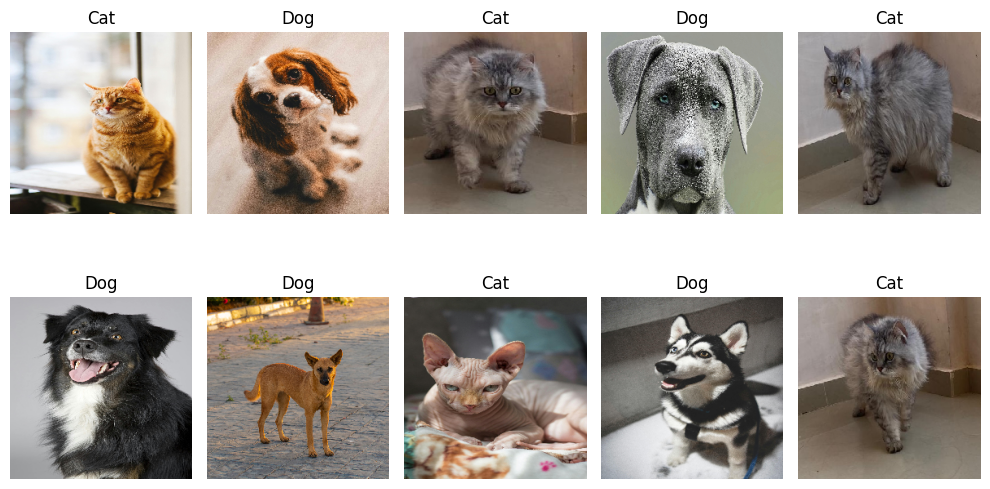

In [ ]:
import matplotlib.pyplot as plt
# Labeling the data
Labels = [0, 1, 0, 1, 0, 1, 1, 0, 1, 0]
# Initialize a list to hold image-label pairs
image_label_pairs = []

# Iterate through the images and labels, pairing them together
for img_tensor, label in zip(image_arrays, Labels):
    image_label_pairs.append((img_tensor, label))

# Set up the figure with 2 rows and 5 columns (total 10 images)
fig, axes = plt.subplots(2, 5, figsize=(10, 6))  # 2 rows, 5 columns

# Iterate over the first 10 image-label pairs
for i, (img_tensor, label) in enumerate(image_label_pairs[:10]):
    row = i // 5  # Calculate the row index (0 or 1)
    col = i % 5   # Calculate the column index (0 to 4)

    # Plot each image on its respective subplot
    ax = axes[row, col]
    ax.imshow(img_tensor[0])  # Remove batch dimension for display
    ax.set_title("Cat" if label == 0 else "Dog")  # Display the label as title
    ax.axis('off')  # Hide axis

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf

# Function to predict and compare with actual labels
def predict_and_compare(model, image_label_pairs):
    predicted_labels = []  # Initialize an empty list to store predicted labels
    for i, (img_tensor, actual_label) in enumerate(image_label_pairs):
        # Predict the output (probabilities) for the image
        prediction = model.predict(img_tensor)

        # Convert probabilities to binary predictions (Cat: 0, Dog: 1)
        predicted_label = np.where(prediction > 0.5, 1, 0).flatten()[0]  # Convert and get a single value
        predicted_labels.append(predicted_label)  # Append the predicted label to the list
        # Print predicted vs actual label
        print(f"Image {i+1}:")
        print(f"  Actual label: {'Cat' if actual_label == 0 else 'Dog'}")
        print(f"  Predicted label: {'Cat' if predicted_label == 0 else 'Dog'}\n")
    return predicted_labels
# Call the function with your model and image-label pairs
predicted_labels = predict_and_compare(model, image_label_pairs)
print("Actual Labels:    ",Labels)
print("Predicted Labels: ",predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image 1:
  Actual label: Cat
  Predicted label: Cat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image 2:
  Actual label: Dog
  Predicted label: Dog

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image 3:
  Actual label: Cat
  Predicted label: Cat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image 4:
  Actual label: Dog
  Predicted label: Dog

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image 5:
  Actual label: Cat
  Predicted label: Cat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image 6:
  Actual label: Dog
  Predicted label: Dog

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image 7:
  Actual label: Dog
  Predicted label: Dog

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image 8:
  Actual label: Cat
  Predicted label: Cat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image 9:
  Actual label: Dog
  Predicted label: Dog

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image 10:
  Actual label: Cat
  Predicted label: Dog

Actual Labels:     [0, 1, 0, 1, 0, 1, 1, 0, 1, 0]
Predicted Labels:  [0, 1, 0, 1, 0, 1, 1